In [1]:
from gurobipy import *
import time
import pandas as pd
from scipy.spatial.distance import euclidean
import networkx as nx

In [2]:
path = 'customers.txt'
# read text file
with open(path, encoding='utf8') as f:
    lines = f.readlines()
    
rows = []
for line in lines:
    row = line.strip().split('\t')
    rows.append(row)
df = pd.DataFrame(rows, columns = rows[0])
df = df.drop(0)
df = df.set_index('CUST NO.')

first_row = df.iloc[0]
df = pd.concat([df, first_row.to_frame().transpose()], ignore_index=True)
df = df.astype({'X COORD.': 'float', 'Y COORD.': 'float', 'POPULATION NO.': 'int', 'SURVIVAL_PROBABILITY': 'float'})
df.head()

,X COORD.,Y COORD.,POPULATION NO.,SURVIVAL_PROBABILITY
0,0.0,0.0,0,1.00
1,0.0,1.0,1,0.80
2,0.0,2.0,3,1.05
3,0.0,3.0,2,2.68
4,0.0,4.0,2,3.20


In [4]:
Ndrones = 2 # Número de drones
k = Ndrones
n = len(df) - 2 # Número de clientes


N = range(1, len(df.index) - 1) # Índice de clientes {1, 2, ..., n}
V = range(len(df.index)) # Índice de clientes y depósito {0, 1, ..., n+1}
S = range(1,Ndrones + 1) # Índice de rutas inicales 


T = 12 # Time limit


# Se crean los arcos del grafo
arcos = []
for i in V:
    for j in V:
        if i != j:
            if i != len(V) - 1 and j != 0:
                arcos.append(tuple((i,j)))
arcos.remove((0, len(df) - 1))



# Se calculan los costos (distancias)

t = {} # Tiempo en minutos
for arc in arcos:
    point1 = df.loc[arc[0], ['X COORD.', 'Y COORD.']].values
    point2 = df.loc[arc[1], ['X COORD.', 'Y COORD.']].values
    distance = euclidean(point1, point2)
    t[arc] = distance
    
    
    
# Parameter that accounts for the population of node j
l = {(i,j): df['POPULATION NO.'][j] for (i,j) in arcos}   

# Probability of vulnerability of node j
P_ij = {(i,j): df['SURVIVAL_PROBABILITY'][j] if j != len(df)-1 else 0 for (i,j) in arcos}
 
# Weights for each objective in the FO
w1 = 1
w2 = 1

# Cost of node j (by entering j independent of i)
c = {(i,j): w1 * l[i,j] + w2 * P_ij[i,j] for (i,j) in arcos}




G = nx.DiGraph()
G.add_edges_from(arcos)

    
contador_s = 0
T_acum = 0
b_ijs = {}




b_ijs = {(i,j,s): 1 if (i == 0 and j == s) or (j == len(df)-1 and i == s) else 0 for (i,j) in arcos for s in S }

a_is = {(i,s): sum(b_ijs[i,j,s] for j in G.successors(i)) for i in G.nodes for s in S if i <= len(df)-2}

c_s = {s: sum(c[i,j] * b_ijs[i,j,s] for (i,j) in arcos) for s in S}

In [5]:
modelMP = Model('MasterProblem')

# Variables

theta = {s: modelMP.addVar(vtype = GRB.CONTINUOUS, obj = c_s[s], name = 'theta' + str(s)) for s in S}

# Constraints

Ctrs = []
for i in N:
    Ctrs.append(modelMP.addConstr(quicksum(a_is[i,s]*theta[s] for s in S) <= 1, name = str(i)))

Ctrs.append(modelMP.addConstr(quicksum(theta[s] for s in S) <= k))



# Maximise
modelMP.ModelSense = -1


# Model's parameters
modelMP.setParam("OutputFlag", 0) 
modelMP.setParam("DualReductions", 0)
modelMP.setParam("InfUnbdInfo", 1)
modelMP.setParam('Threads', 8)
modelMP.update()

Set parameter Username
Academic license - for non-commercial use only - expires 2024-01-18


In [6]:
m = Model('AuxProblem')


# Variables

b = {(i,j): m.addVar(vtype = GRB.BINARY, name = 'b' + str(i)+str(j)) for (i,j) in arcos}

start_node = 0
end_node = n+1


# Constraints

# Exit origin node only once
m.addConstr(quicksum(b[start_node, j] for j in N) == 1)

# Enter destination node only once
m.addConstr(quicksum(b[i, end_node] for i in N) == 1)

# Flow constraints
for i in N:
    m.addConstr(quicksum(b[i,j] for j in G.successors(i)) - quicksum(b[j,i] for j in G.predecessors(i)) == 0)


### Chat GPT


# Add binary variable for each node to track whether it is visited in the path
z = {}
for i in G.nodes():
    z[i] = m.addVar(vtype=GRB.BINARY, name='z_{0}'.format(i))    
    
# Add MTZ constraints for each node (except start and end)
M = G.number_of_nodes() + 1
u = {}
for i in G.nodes():
    if i != start_node and i != end_node:
        u[i] = m.addVar(vtype=GRB.CONTINUOUS, name='u_{0}'.format(i))

for i in G.nodes():
    if i != start_node and i != end_node:
        for j in G.nodes():
            if j != start_node and j != end_node and i != j:
                expr = u[i] - u[j] + M * b[i, j] <= M - 1 - M * (1 - z[j])
                m.addConstr(expr)


                
# Resource constraint (time)
m.addConstr(quicksum(t[i,j]*b[i,j] for (i,j) in arcos) <= T)



# Maximise
m.ModelSense = -1


# Model's parameters
m.setParam("OutputFlag", 0) 
m.setParam("DualReductions", 0)
m.setParam("InfUnbdInfo", 1)
m.setParam('Threads', 8)

m.update()

In [6]:
init_time = time.time()
notOptimal = True


GAP = 0.3 # Optimality gap in %
time_limit = 10000 # time limit in minutes


contador = 0
new_columns = []
a_iC = 0
routes = {}

ruta = []
rutaa = []

while  notOptimal:
    
    # Linear relaxtion MP
    modelMP.optimize()
    
    
    # Dual variables
    duals = modelMP.getAttr('Pi', modelMP.getConstrs())
    OF = modelMP.objVal
    
    
    # Calculate auxiliary's problem cost using dual variables of the relaxed master problem
    c_q = {(i,j): c[i,j] - duals[i-1] if i in N else c[i,j] for (i,j) in arcos}
    #print(duals)
    
    
    # Set gradient in the auxiliary problem
    m.setObjective(quicksum(c_q[i,j]*b[i,j] for (i,j) in arcos))
    
    
    
    m.setParam('OutputFlag', 0)
    # Sets stopping criteria
    m.setParam('MIPGap', GAP)
    m.setParam('TimeLimit', 60*time_limit)
    m.update()
    m.optimize()
    
    
    # Saves reduced cost of auxiliary problem
    reduced_cost = m.objVal - duals[-1]
    
    
    
    # Save last column
    a_i_old = a_iC

    # Calculates new column based on decision variable b_ij
    a_iC = {(i): sum(b[i,j].x for j in G.successors(i)) for i in N}
    a_iC = list(a_iC.values())
    a_iC.append(1)
    
    # Calculates new route cost based on decision variable b_ij
    new_cost = sum(c[i,j] * b[i,j].x for (i,j) in arcos)
    
    

    # Saves route for new column
    ruta = []
    rutaa = []
    for (i,j) in arcos:
        if b[i,j].x >= 0.5:
            ruta.append(tuple((i,j))) 
            rutaa.append([tuple((i,j))])
    
    
    
    # Checks for optimality criteria
    if reduced_cost <= 0:
        print('Column generation stops! with a reduced cost of:', reduced_cost)
        print('Best MP upper bound:', OF)
        notOptimal = False
    else:
        
        # Saves new column
        newCol = Column(a_iC, Ctrs)
        
        # Adds new variable based on new column 
        modelMP.addVar(vtype = GRB.CONTINUOUS, lb = 0, obj = new_cost, column = newCol)
        modelMP.update()  

        
        # Cut to prevent routes already added
        m.addConstr(quicksum(b[i,j] for (i,j) in ruta) <= len(ruta) - 1)
        m.update()
        
        
  
        routes[contador+k+1] = rutaa
        c_s[contador+k+1] = new_cost
        
        
        # Saves columns added
        new_columns.append(a_iC)
        contador += 1
        
        #if contador % 10 == 0:
        print('colmumn:',a_iC)
        print('reduced cost:',reduced_cost)
        print('RMP OF:', OF)

            
            
# Set variables to binary in the master problem        
for v in modelMP.getVars():
    v.setAttr('vtype', GRB.BINARY)
    
# Solve original master problem
modelMP.optimize()
print('Integer MP OF:', modelMP.objVal)
tiempo = round(time.time()-init_time,4)
print('Computational time:', tiempo)

colmumn: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1]
reduced cost: 16483.0
RMP OF: 929.0
colmumn: [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1]
reduced cost: 15511.0
RMP OF: 17011.0
colmumn: [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1]
reduced cost: 14319.0
RMP OF: 17011.0
colmumn: [1.0, 0.0, 0.0, 0.0, 0.0, 1.0, -1.3877787807814457e-17, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1]
reduced cost: 14369.0
RMP OF: 17011.0
colmumn: [0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1]
reduced cost: 12905.0
RMP OF: 17011.0
colmumn: [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.

In [7]:
opt_routes = {}
for i in range(len(modelMP.x)):
    if modelMP.x[i] >= 0.5 and i > k-1:
        print('Route', i+1,':',routes[i+1])
        opt_routes[i+1] = routes[i+1]

Route 24 : [[(0, 16)], [(6, 25)], [(12, 6)], [(16, 21)], [(17, 12)], [(18, 17)], [(21, 22)], [(22, 23)], [(23, 18)]]
Route 28 : [[(0, 8)], [(1, 25)], [(2, 1)], [(3, 2)], [(8, 13)], [(9, 3)], [(13, 19)], [(14, 9)], [(19, 14)]]


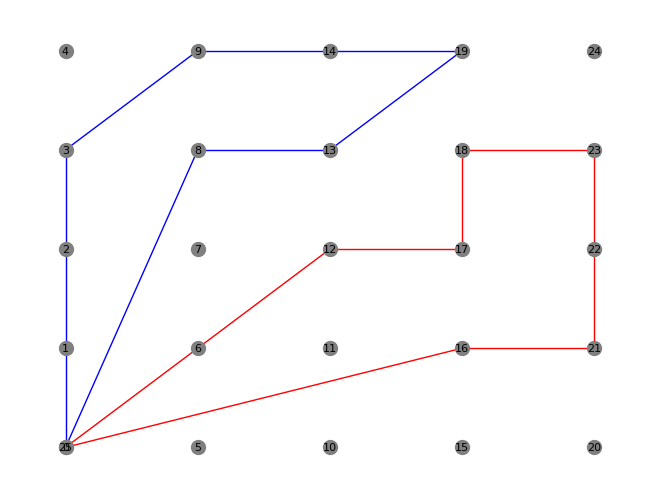

In [8]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

# assume your dataframe is called 'df'
coord_dict = {idx: (row['X COORD.'], row['Y COORD.']) for idx, row in df.iterrows()}

# assume coord_dict is the dictionary of node coordinates
# assume routes_dict is the dictionary of routes

# create an empty graph
G = nx.Graph()

# add nodes to the graph using the coordinates from coord_dict
for idx, coords in coord_dict.items():
    G.add_node(idx, pos=coords)

# add edges to the graph using the routes in routes_dict
colors = ['red', 'blue', 'green', 'orange', 'purple', 'pink'] # define a list of colors for the routes
for idx, (route_id, route) in enumerate(opt_routes.items()):
    for edge in route:
        G.add_edge(edge[0][0], edge[0][1], color=colors[idx]) # add the edge color for each route

# draw the graph using the node positions and edge colors
pos = nx.get_node_attributes(G, 'pos')
edge_colors = [G[u][v]['color'] for u,v in G.edges()] # set the edge colors based on the color attribute of each edge
nx.draw(G, pos, node_size=100, node_color='grey', with_labels=True, font_size=8, edge_color=edge_colors)

# show the plot
plt.show()


In [9]:
reduced_cost = m.objVal - duals[-1]

In [10]:
m.objVal

9537.846153846152

In [11]:
duals[-1]

9537.846153846152